In [1]:
import time
import random
import os
import cv2
import numpy as np
import pandas as pd
import gc

from PIL import Image
from openslide import OpenSlide, OpenSlideUnsupportedFormatError

import xml.etree.cElementTree as ET
from shapely.geometry import box, Point, Polygon

from matplotlib import pyplot as plt
import matplotlib.patches as patches

from ast import literal_eval

import pickle

import multiprocessing
# TEA-graph-master/WSI-analysis/patch_extraction/extract_patches_split.py

from extract_patch_model.extract_patches_split import \
openSlide_init, read_wsi, construct_colored_wsi, get_contours, \
segmentation_hsv, construct_bags, save_to_disk, parse_annotation, \
preprocessingAndanalysis, draw_pospatch, calculate_intersection, \
calculate_polygon, calc_tumorArea, \
extract_all_Plus

'''
    Global
'''
PATCH_SIZE = 512
CHANNEL = 3
# 90
THRESH = 75

PIXEL_WHITE = 255
PIXEL_TH = 200
PIXEL_BLACK = 0

SPLIT = 4

In [2]:
training_dir='/NAS1/HnE_images/original/CNU/LUAD/MRXS/'
anno_dir = './lung_dataset/patch_dataset/anno_xml/'

slideEnd='.mrxs'
annoEnd='-tumor-AI.xml'

In [ ]:
# slide_path_ = os.listdir(training_dir)
# anno_path_ = os.listdir(anno_dir)
# slide_path_ = [item for c, item in enumerate(slide_path_) if '.mrxs' in item]

# level=2
# mag_factor=pow(2, level)

# def openSlide_init(tif_file_path, level):
#     '''
#         Identifies the slide and initializes OpenSlide object.

#         Returns:
#             - wsi_obj: OpenSlide object to the target WSI.
#     '''
#     try:
#         wsi_obj = OpenSlide(tif_file_path)

#     except OpenSlideUnsupportedFormatError:
#         print('Exception: OpenSlideUnsupportedFormatError')
#         return None
#     else:
#         slide_w_, slide_h_ = wsi_obj.level_dimensions[level]
#         print('level' + str(level), 'size(w, h):', slide_w_, slide_h_)
        
#         return wsi_obj

# for anno_files in anno_path_:
#     print(anno_files)
#     ID = anno_files.replace("-tumor-AI.xml", "")
    
#     wsi = training_dir + ID + '.mrxs'
#     anno = anno_dir + anno_files
    
#     wsi_obj=openSlide_init(wsi, level)
#     polygon_list, anno_list = parse_annotation(anno, level, mag_factor)

#     sample_level=8
#     sample_mag_factor=pow(2, sample_level)

#     width_sample, height_sample = wsi_obj.level_dimensions[sample_level]
#     rgba_image_thumbnail = wsi_obj.read_region((0,0), sample_level, \
#                                        (width_sample, height_sample))
#     del rgba_image_thumbnail
#     gc.collect()
    
#     sect = '12' #21 and 12 are different

#     rgba_image = read_wsi(wsi_obj, level, mag_factor, sect)
#     wsi_rgb_, wsi_gray_, wsi_hsv_ = construct_colored_wsi(rgba_image)
#     del rgba_image
#     gc.collect()
    
#     bounding_boxes, contour_coords, contours, mask \
#                     = segmentation_hsv(wsi_hsv_, wsi_rgb_)
#     del wsi_hsv_
#     gc.collect()
    
#     patches, patches_coords, patches_coords_local\
#         = construct_bags(wsi_obj, wsi_rgb_, contours, mask, level, mag_factor, \
#                  sect, PATCH_SIZE, SPLIT)
    
#     tumor_dict = calc_tumorArea(polygon_list, patches_coords)

#     if len(patches):
#         save_to_disk(patches, patches_coords, tumor_dict, mask, \
#                      wsi, level, sect)

In [ ]:
# !rm -r ./lung_dataset/patches_512/*.png

In [131]:
# '''
#     For level1 WSIs, we mannully split the whole slide into 16(4*4) sections.
# '''
# section_list = ['00', '01', '02', '03', \
#                 '10', '11', '12', '13', \
#                 '20', '21', '22', '23', \
#                 '30', '31', '32', '33']

slide_ = '88-1'

In [132]:
slide_path_ = training_dir + slide_ + slideEnd
anno_path_ = anno_dir + slide_ + annoEnd

print("slide file path:", slide_path_)
print("annotation xml path:", anno_path_)

assert(os.path.isfile(slide_path_) == True)
assert(os.path.isfile(anno_path_) == True)

slide file path: /NAS1/HnE_images/original/CNU/LUAD/MRXS/88-1.mrxs
annotation xml path: ./lung_dataset/patch_dataset/anno_xml/88-1-tumor-AI.xml


In [133]:
level=2
mag_factor=pow(2, level)

wsi_obj=openSlide_init(slide_path_, level)

level2 size(w, h): 44736 99712


In [134]:
'''
    Parse annotation xml
'''
polygon_list, anno_list = parse_annotation(anno_path_, level, mag_factor)


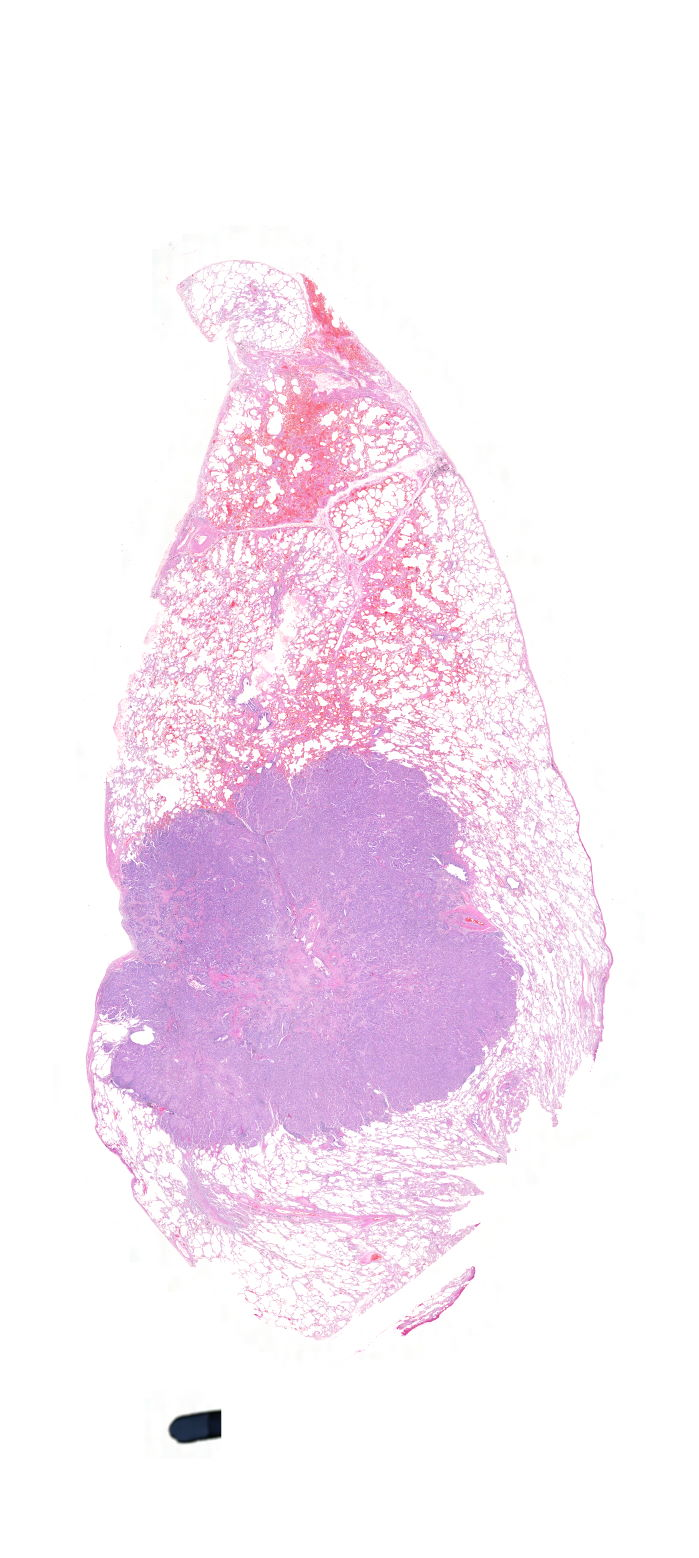

In [135]:
'''
    Display thumbnail
'''

sample_level=8
sample_mag_factor=pow(2, sample_level)

width_sample, height_sample = wsi_obj.level_dimensions[sample_level]
rgba_image_thumbnail = wsi_obj.read_region((0,0), sample_level, \
                                           (width_sample, height_sample))
# cv2.rectangle(rgba_image_thumbnail, (10, 10), (10, 10), (0, 255, 0))

rgba_image_thumbnail

In [136]:
del rgba_image_thumbnail
gc.collect()

49

In [137]:
sect = '12' #21 and 12 are different

rgba_image = read_wsi(wsi_obj, level, mag_factor, sect)

level1 dimension (width, height):  44736 99712
section size (width, height):  11184 24928
rgba image dimension (width, height): (11184, 24928)
transformed: (24928, 11184, 4)
Time spent on loading WSI section into memory:  7.3498780727386475


In [138]:
wsi_rgb_, wsi_gray_, wsi_hsv_ = construct_colored_wsi(rgba_image)

print(type(wsi_rgb_))
print(wsi_rgb_.shape)

print(type(wsi_gray_))
print(wsi_gray_.shape)

print(type(wsi_hsv_))
print(wsi_hsv_.shape)

<class 'numpy.ndarray'>
(24928, 11184, 3)
<class 'numpy.ndarray'>
(24928, 11184)
<class 'numpy.ndarray'>
(24928, 11184, 3)


In [139]:
del rgba_image
gc.collect()

70

In [140]:
bounding_boxes, contour_coords, contours, mask \
= segmentation_hsv(wsi_hsv_, wsi_rgb_)

HSV segmentation step
Getting Contour: 
contour image dimension:  (24928, 11184)
mask image dimension:  (24928, 11184, 3)


In [141]:
print("Number of contours:", len(contour_coords))
print("Contour shape: ", contour_coords[1].shape)
# print('mask: ', mask)
print(contour_coords[1])

Number of contours: 14342
Contour shape:  (7, 2)
[[ 2730 24924]
 [ 2729 24925]
 [ 2729 24927]
 [ 2736 24927]
 [ 2736 24925]
 [ 2735 24925]
 [ 2734 24924]]


In [142]:
print(contour_coords[0].shape)
print(np.expand_dims(contour_coords[0], axis=1).shape)

print(contours[0].shape)
print(np.squeeze(contours[0]).shape)

(4, 2)
(4, 1, 2)
(4, 1, 2)
(4, 2)


In [143]:
del wsi_hsv_
gc.collect()

63

In [144]:
patches, patches_coords, patches_coords_local\
= construct_bags(wsi_obj, wsi_rgb_, contours, mask, level, mag_factor, \
                 sect, PATCH_SIZE, SPLIT)

Total number of patches extracted:  763


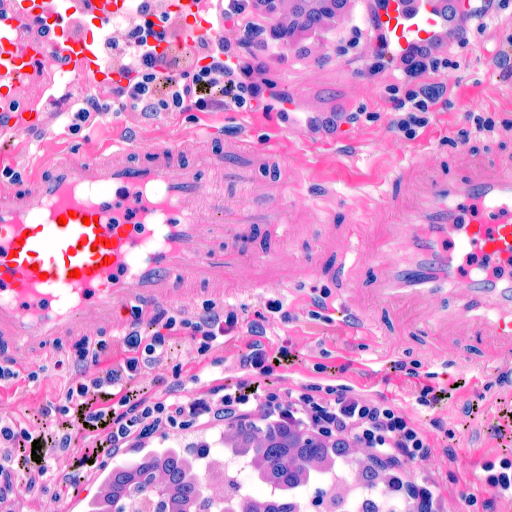

In [145]:
# for i in patches:
Image.fromarray(patches[0])  

In [146]:
patches_coords_local[:10]

[(4608, 0),
 (5120, 0),
 (5632, 0),
 (6144, 0),
 (6656, 0),
 (7168, 0),
 (7680, 0),
 (8192, 0),
 (8704, 0),
 (9216, 0)]

In [147]:
patches_coords[:10]

[(15792, 49856),
 (16304, 49856),
 (16816, 49856),
 (17328, 49856),
 (17840, 49856),
 (18352, 49856),
 (18864, 49856),
 (19376, 49856),
 (19888, 49856),
 (20400, 49856)]

In [148]:
# calculate tumor area in each patch.
tumor_dict = calc_tumorArea(polygon_list, patches_coords)

if len(patches):
    save_to_disk(patches, patches_coords, tumor_dict, mask, \
                 slide_path_, level, sect)

Path:  ./lung_dataset/patches_512/patch_
Number of patches:  763


In [ ]:
# !rm -r ./dataset2
# !rm -r ./data/data/val_test/train/mask/*.npy